# **Laboratorul 11 PMP**

In [1]:
!pip -q install pymc arviz numpy pandas

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Prices.csv to Prices.csv


In [8]:
df = pd.read_csv("Prices.csv")

y = df["Price"].astype(float).values
x1 = df["Speed"].astype(float).values
x2 = np.log(df["HardDrive"].astype(float).values)

x1_mean = x1.mean()
x2_mean = x2.mean()
x1_c = x1 - x1_mean
x2_c = x2 - x2_mean


## **a)**

Output()

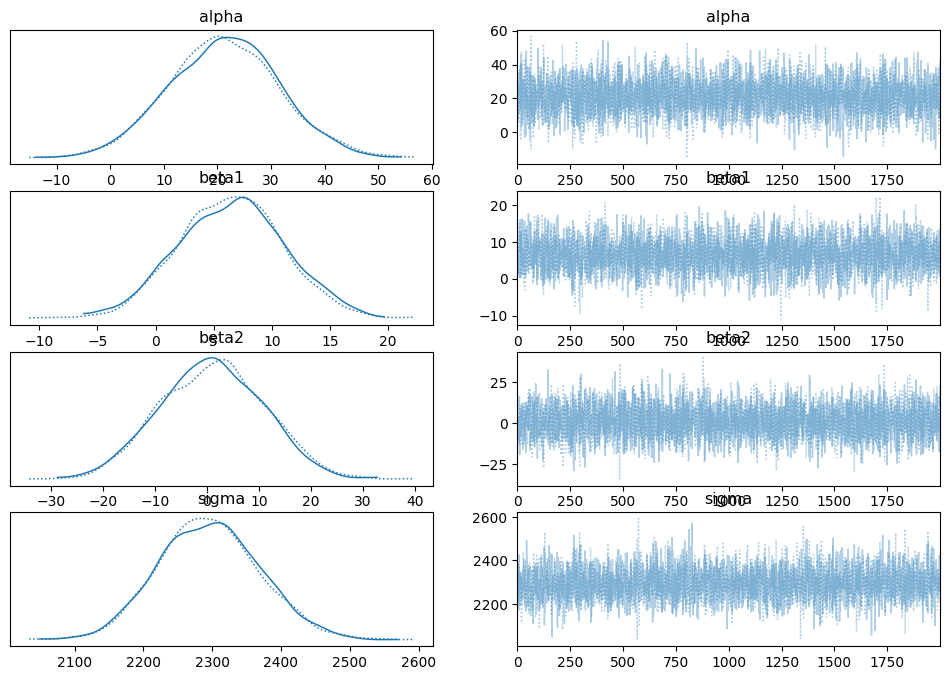

In [9]:


with pm.Model() as model_basic:
    x1_shared = pm.Data("x1_shared", x1_c)
    x2_shared = pm.Data("x2_shared", x2_c)

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=5)

    mu = pm.Deterministic("mu", alpha + beta1 * x1_shared + beta2 * x2_shared)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    idata_basic = pm.sample(draws=2000, tune=2000, chains=2, target_accept=0.9, random_seed=42)

az.plot_trace(idata_basic, var_names=["alpha", "beta1", "beta2", "sigma"])
plt.show()


## **b)**

In [10]:
summary_95 = az.summary(idata_basic, var_names=["beta1","beta2"], hdi_prob=0.95)
summary_95


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,6.479,4.541,-1.860,15.695,0.072,0.065,3993.0,3232.0,1.0
beta2,0.997,9.927,-18.171,19.702,0.145,0.144,4667.0,3243.0,1.0


## **c)**

In [12]:
def hdi_excludes_zero_from_summary(idata, var, hdi_prob=0.95):
    s = az.summary(idata, var_names=[var], hdi_prob=hdi_prob)
    low  = float(s.loc[var, f"hdi_{(1-hdi_prob)/2*100:.1f}%"])
    high = float(s.loc[var, f"hdi_{(1+(hdi_prob))/2*100:.1f}%"])
    excludes = (high < 0) or (low > 0)
    return excludes, (low, high), s

b1_ok, b1_hdi, _ = hdi_excludes_zero_from_summary(idata_basic, "beta1", 0.95)
b2_ok, b2_hdi, _ = hdi_excludes_zero_from_summary(idata_basic, "beta2", 0.95)

print("beta1 95% HDI:", b1_hdi, "=> util?", b1_ok)
print("beta2 95% HDI:", b2_hdi, "=> util?", b2_ok)


beta1 95% HDI: (-1.86, 15.695) => util? False
beta2 95% HDI: (-18.171, 19.702) => util? False


## **d)**

In [13]:
x1_new = 33.0
x2_new = np.log(540.0)

x1_new_c = x1_new - x1_mean
x2_new_c = x2_new - x2_mean

with model_basic:
    pm.set_data({"x1_shared": np.array([x1_new_c]),
                 "x2_shared": np.array([x2_new_c])})

    post = idata_basic.posterior.stack(sample=("chain","draw"))
    mu_new = (post["alpha"] + post["beta1"]*x1_new_c + post["beta2"]*x2_new_c).values

mu_new_hdi90 = az.hdi(mu_new, hdi_prob=0.90)
mu_new.mean(), mu_new_hdi90


(np.float64(-101.48770961723677), array([-243.23587709,   41.06173029]))

## **e)**

In [15]:
with pm.Model() as model_pred:
    x1_shared = pm.Data("x1_shared", x1_c)
    x2_shared = pm.Data("x2_shared", x2_c)

    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=5)

    mu = alpha + beta1 * x1_shared + beta2 * x2_shared

    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    y_new = pm.Normal("y_new", mu=mu, sigma=sigma)

    idata_pred = pm.sample(
        draws=2000, tune=2000,
        chains=2, target_accept=0.9,
        random_seed=42
    )

with model_pred:
    pm.set_data({
        "x1_shared": np.array([x1_new_c]),
        "x2_shared": np.array([x2_new_c])
    })

    ppc = pm.sample_posterior_predictive(
        idata_pred,
        var_names=["y_new"],
        random_seed=42
    )

y_new_draws = ppc.posterior_predictive["y_new"].stack(sample=("chain","draw")).values
pred_hdi90 = az.hdi(y_new_draws, hdi_prob=0.90)

print("E[y_new | x] ~", float(np.mean(y_new_draws)))
print("90% HDI prediction interval:", pred_hdi90)

Output()

Output()

E[y_new | x] ~ -56.94425560083856
90% HDI prediction interval: [[ 896.39166491  896.39166491]
 [1286.53858172 1286.53858172]
 [ -97.70403315  -97.70403315]
 ...
 [-107.44587755 -107.44587755]
 [1369.97738364 1369.97738364]
 [3204.74490331 3204.74490331]]


/tmp/ipython-input-3532148165.py:40: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  pred_hdi90 = az.hdi(y_new_draws, hdi_prob=0.90)
